<h1>Spam Detection Model</h1>
<h5>Created by: Cristopher Ian Artacho</h5>
<h5>BSCS 3A</h5>

<h5>Using a dataset from kaggle, the aim of this project is to train a model that could identify a message to be "spam" or "not spam".</h5>

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

nltk.download("stopwords")
from nltk.corpus import stopwords

import joblib

[nltk_data] Downloading package stopwords to C:\Users\Cristopher
[nltk_data]     Artacho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1>Data Exploration and Preprocessing</h1>
<h5>In this process, we will get to understand our data, and the dataset. In case that there are missing values, noise, and/or errors in the data, we will need to clean it in order to reduce the complexity of the data, allowing the model to better understand the dataset. </h5>

In [185]:
df = pd.read_csv('spam.csv')

In [186]:
# CHANGING THE "CATEGORY" COLUMN TO "LABEL"
df.columns = ["Label", "Message"]

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [188]:
for col in df:
    print(df[col].nunique())

2
5157


In [189]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In this part, we notice that the "ham" (not spam) far outnumbers the number of "spam" messages. This might lead to mode biases towards the "ham". Therefore, we will need to reduce the number of ham messages to match the number of spam messages.

In [190]:
# MAPPING THE VALUES OF LABEL FROM CATEGORICAL TO NUMERICAL
df["Label"] = df["Label"].map({"spam": 1, "ham": 0})

In [191]:
ham_df = df[df["Label"] == 0]
spam_df = df[df["Label"] == 1]

In [192]:
# RANDOM SELECTION FOR "ham" MESSAGES
ham_sample = ham_df.sample(n=len(spam_df), random_state=42)

In [193]:
df= pd.concat([ham_sample, spam_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [194]:
print(df["Label"].value_counts())

Label
1    747
0    747
Name: count, dtype: int64


<h1>Text Preprocessing and Feature Engineering</h1>
<h5>In this process, we will transform the text to its most basic format, without numbers, stopwords and punctuation that would be unecessary and unrelated to the data.</h5>

In [195]:

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r"\d+", "", text)  
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]
    return " ".join(words)

In [196]:
df["Processed_Message"] = df["Message"].apply(preprocess_text)

We will create a new column that will contain the preprocessed text and separate it from the original

In [197]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Processed_Message"])
y = df["Label"]


TF-IDF (Term Frequency-Inverse Document Frequency) determines how important is the word based on how many times it appeared in the text, we will use this in order to detect the words that belong to the "spam" and "ham" classes

<h1>Training the Model</h1>
<h5>After cleaning the data, and processing the text, it is time to train the model in order to help it classify which messages are "spam" and which are "ham". For this, we will use Multinomial Naive Bayes that assumes the frequency of words to classify.</h5>

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [199]:
# FOR THE NAIVE BAYES
MNBmodel = MultinomialNB()
MNBmodel.fit(X_train, y_train)


MultinomialNB()

In [200]:
# FOR THE LOGISTIC REGRESSION
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)

LogisticRegression()

In [201]:
# FOR THE SVM
SVMmodel = SVC(kernel="linear")  # Linear kernel is effective for text classification
SVMmodel.fit(X_train, y_train)

SVC(kernel='linear')

In [202]:
# MULTINOMIAL NAIVE BAYES PREDICTION
MNBy_pred = MNBmodel.predict(X_test)

In [203]:
# LOGISTIC REGRESSION PREDICTION
LRy_pred = LRmodel.predict(X_test)

In [204]:
# Predictions
SVMy_pred = SVMmodel.predict(X_test)

<h1>Model Evaluation</h1>
<h5>After training the model, we will use Evaluation metrics in order to judge if the model's predictions are correct.</h5>
<h5></h5>

In [205]:
# MULTINOMIAL NAIVE BAYES PERFORMANCE
accuracy = accuracy_score(y_test, MNBy_pred)
f1 = f1_score(y_test, MNBy_pred)
report = classification_report(y_test, MNBy_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, MNBy_pred))


Accuracy: 0.9398
F1 Score: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       150
           1       0.97      0.91      0.94       149

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299



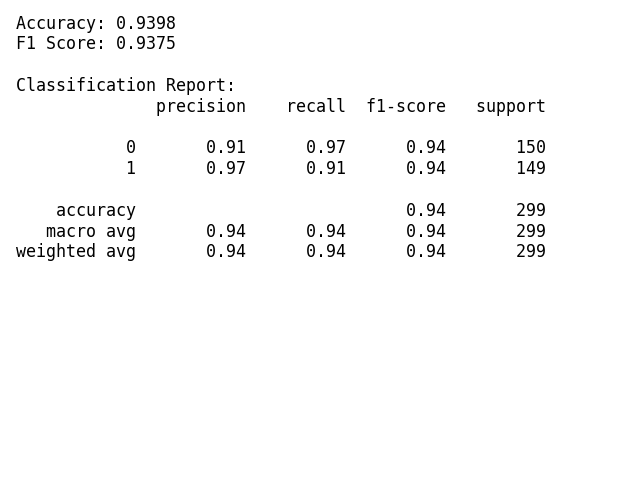

In [206]:
text_output = f"Accuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}\n\nClassification Report:\n{report}"

plt.figure(figsize=(8, 6))
plt.text(0.01, 0.99, text_output, fontsize=12, ha='left', va='top', family="monospace")
# Hide axes
plt.axis("off")

plt.savefig("MNBclassification_report.png", bbox_inches="tight", dpi=300)
plt.show()

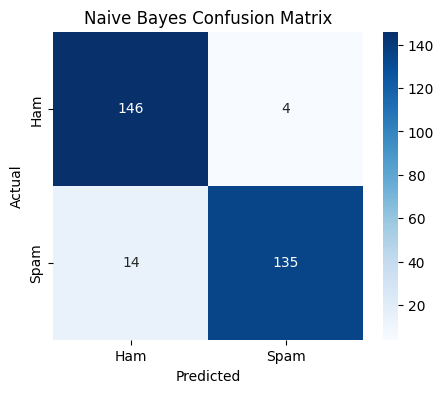

In [207]:
conf_matrix = confusion_matrix(y_test, MNBy_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")

plt.savefig("MNBconfusion_matrix.png")
plt.show()
plt.close() 

In [208]:
#SAVING THE MODEL AS A .pkl FILE
joblib.dump(MNBmodel, "MNBspam_classifier_model.pkl")

#SAVING THE VECTORIZER AS A .pkl FILE
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [209]:
# LOGISTIC REGRESSION PERFORMANCE
LRaccuracy = accuracy_score(y_test, LRy_pred)
LRf1 = f1_score(y_test, LRy_pred)
LRreport = classification_report(y_test, LRy_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", LRreport)

Accuracy: 0.9398
F1 Score: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       150
           1       0.98      0.85      0.91       149

    accuracy                           0.91       299
   macro avg       0.92      0.91      0.91       299
weighted avg       0.92      0.91      0.91       299



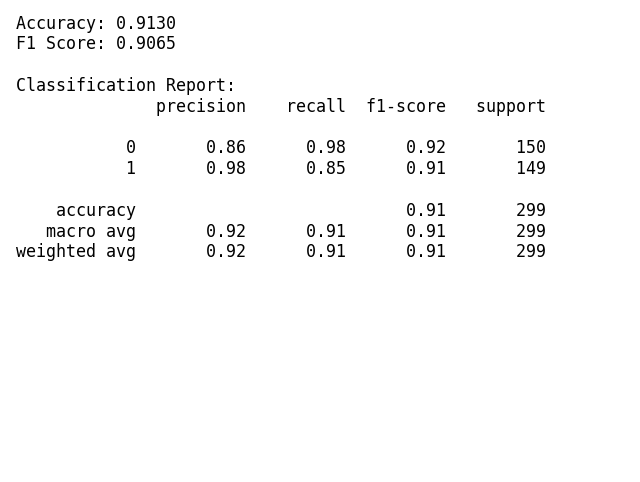

In [210]:
# Save Logistic Regression report as image
LR_text_output = f"Accuracy: {LRaccuracy:.4f}\nF1 Score: {LRf1:.4f}\n\nClassification Report:\n{LRreport}"

plt.figure(figsize=(8, 6))
plt.text(0.01, 0.99, LR_text_output, fontsize=12, ha="left", va="top", family="monospace")
plt.axis("off")
plt.savefig("LRclassification_report.png", bbox_inches="tight", dpi=300)
plt.show()


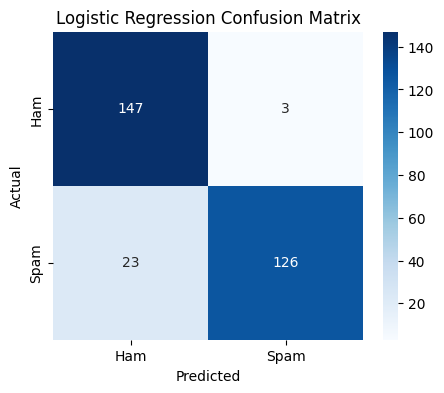

In [211]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, LRy_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.savefig("LRconfusion_matrix.png")
plt.show()


In [212]:
# Save the trained model
joblib.dump(LRmodel, "LRspam_classifier_model.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [213]:
# SVM PREFORMANCE
SVMaccuracy = accuracy_score(y_test, SVMy_pred)
SVMf1 = f1_score(y_test, SVMy_pred)
SVM_report = classification_report(y_test, SVMy_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", SVM_report)


Accuracy: 0.9398
F1 Score: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       150
           1       0.98      0.88      0.93       149

    accuracy                           0.93       299
   macro avg       0.94      0.93      0.93       299
weighted avg       0.94      0.93      0.93       299



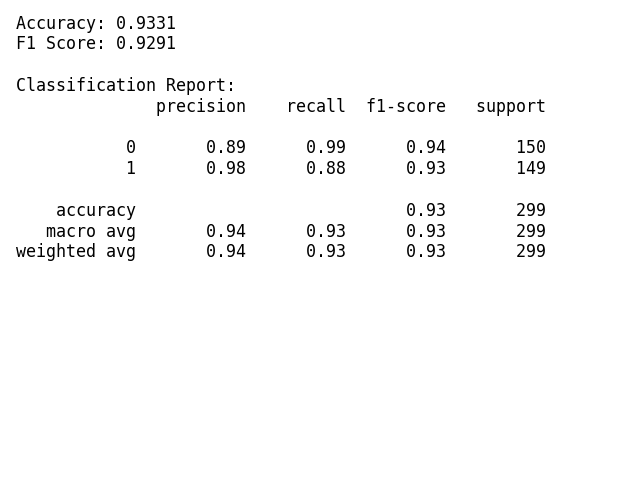

In [214]:
# Save SVM report as image
SVM_text_output = f"Accuracy: {SVMaccuracy:.4f}\nF1 Score: {SVMf1:.4f}\n\nClassification Report:\n{SVM_report}"

plt.figure(figsize=(8, 6))
plt.text(0.01, 0.99, SVM_text_output, fontsize=12, ha="left", va="top", family="monospace")
plt.axis("off")
plt.savefig("SVM_classification_report.png", bbox_inches="tight", dpi=300)
plt.show()


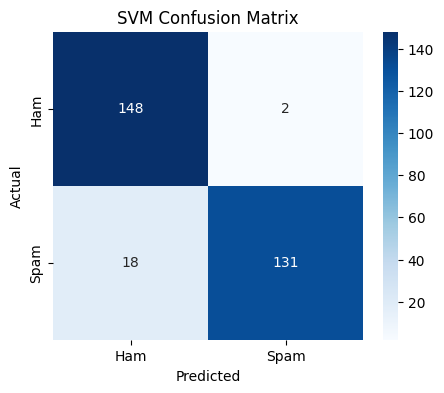

In [215]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, SVMy_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.savefig("SVMconfusion_matrix.png")
plt.show()


In [216]:
# Save the trained model
joblib.dump(SVMmodel, "SVMspam_classifier.pkl")
print("SVM model and vectorizer saved successfully!")

SVM model and vectorizer saved successfully!
